# Tujuan Praktikum

1. Mahasiswa dapat memahami dan menerapkan model Gated Recurrent Unit dalam permasalahan Machine Translation

2. Mahasiswa dapat memahami dan membangun algoritma Neural Machine Translation

3. Mahasiswa dapat mengevaluasi model Neural Machine Translation dengan Gated Reccurent Unit

# Gated Recurrent Units (GRU)

Seiring dengan meningkatnya popularitas RNN, terutama arsitektur LSTM selama tahun 2010-an, sejumlah peneliti mulai bereksperimen dengan arsitektur yang lebih sederhana, dengan harapan mempertahankan ide utama dari penggunaan keadaan internal dan mekanisme gerbang perkalian, tetapi dengan tujuan mempercepat komputasi. Gated recurrent unit (GRU). menawarkan versi sel memori LSTM yang lebih sederhana dan sering kali mencapai kinerja yang sebanding, dengan keuntungan menjadi lebih cepat dalam komputasi.

## Gerbang Reset dan Gerbang Pembaruan

Di sini, tiga gerbang LSTM digantikan oleh dua gerbang: *gerbang reset* dan *gerbang pembaruan*. Seperti halnya LSTM, gerbang-gerbang ini diberi aktivasi sigmoid, memaksa nilai mereka berada dalam interval $(0, 1)$. Secara intuitif, gerbang reset mengontrol seberapa banyak dari status sebelumnya yang mungkin masih ingin kita ingat. Demikian pula, gerbang pembaruan memungkinkan kita mengontrol seberapa banyak status baru hanya merupakan salinan dari status lama. Gambar :numref:`fig_gru_1` menggambarkan input untuk gerbang reset dan gerbang pembaruan dalam GRU, yang diberikan oleh input pada langkah waktu saat ini dan status tersembunyi dari langkah waktu sebelumnya. Output dari gerbang-gerbang ini diberikan oleh dua lapisan yang sepenuhnya terhubung dengan fungsi aktivasi sigmoid.

![Menghitung gerbang reset dan gerbang pembaruan dalam model GRU.](gru-1.svg)
:label:`fig_gru_1`

Secara matematis, untuk langkah waktu $t$, misalkan inputnya adalah minibatch $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (jumlah contoh $=n$; jumlah input $=d$) dan status tersembunyi dari langkah waktu sebelumnya adalah $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (jumlah unit tersembunyi $=h$). Maka, gerbang reset $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ dan gerbang pembaruan $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ dihitung sebagai berikut:

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xr}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hr}} + \mathbf{b}_\textrm{r}),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xz}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hz}} + \mathbf{b}_\textrm{z}),
\end{aligned}
$$

di mana $\mathbf{W}_{\textrm{xr}}, \mathbf{W}_{\textrm{xz}} \in \mathbb{R}^{d \times h}$ dan $\mathbf{W}_{\textrm{hr}}, \mathbf{W}_{\textrm{hz}} \in \mathbb{R}^{h \times h}$ adalah parameter bobot dan $\mathbf{b}_\textrm{r}, \mathbf{b}_\textrm{z} \in \mathbb{R}^{1 \times h}$ adalah parameter bias.


## Kandidat Hidden State

Selanjutnya, kita mengintegrasikan gerbang reset $\mathbf{R}_t$ dengan mekanisme pembaruan biasa pada :eqref:`rnn_h_with_state`, yang menghasilkan *kandidat hidden state* $\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ pada langkah waktu $t$:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\textrm{hh}} + \mathbf{b}_\textrm{h}),$$
:eqlabel:`gru_tilde_H`

di mana $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}$ dan $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$ adalah parameter bobot, $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$ adalah bias, dan simbol $\odot$ adalah operator produk Hadamard (elemenwise). Di sini, kita menggunakan fungsi aktivasi tanh.

Hasilnya adalah *kandidat*, karena kita masih perlu menggabungkan aksi dari gerbang pembaruan. Dibandingkan dengan :eqref:`rnn_h_with_state`, pengaruh dari status sebelumnya sekarang dapat dikurangi dengan perkalian elemenwise dari $\mathbf{R}_t$ dan $\mathbf{H}_{t-1}$ pada :eqref:`gru_tilde_H`. Setiap kali entri dalam gerbang reset $\mathbf{R}_t$ mendekati 1, kita mendapatkan kembali RNN biasa seperti yang ada pada :eqref:`rnn_h_with_state`. Untuk semua entri dalam gerbang reset $\mathbf{R}_t$ yang mendekati 0, status tersembunyi kandidat adalah hasil dari MLP dengan $\mathbf{X}_t$ sebagai input. Status tersembunyi yang sudah ada sebelumnya akan *direset* ke nilai default.

Gambar :numref:`fig_gru_2` menggambarkan alur komputasi setelah menerapkan gerbang reset.

![Menghitung status tersembunyi kandidat dalam model GRU.](gru-2.svg)
:label:`fig_gru_2`


## Status Tersembunyi

Akhirnya, kita perlu menggabungkan pengaruh dari gerbang pembaruan $\mathbf{Z}_t$. Ini menentukan sejauh mana status tersembunyi baru $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ mencocokkan status lama $\mathbf{H}_{t-1}$ dibandingkan seberapa banyak ia menyerupai status kandidat baru $\tilde{\mathbf{H}}_t$. Gerbang pembaruan $\mathbf{Z}_t$ dapat digunakan untuk tujuan ini, cukup dengan mengambil kombinasi konveks elemenwise dari $\mathbf{H}_{t-1}$ dan $\tilde{\mathbf{H}}_t$. Ini menghasilkan persamaan pembaruan akhir untuk GRU:

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

Setiap kali gerbang pembaruan $\mathbf{Z}_t$ mendekati 1, kita cukup mempertahankan status lama. Dalam hal ini, informasi dari $\mathbf{X}_t$ diabaikan, yang secara efektif melewati langkah waktu $t$ dalam rantai ketergantungan. Sebaliknya, setiap kali $\mathbf{Z}_t$ mendekati 0, status laten baru $\mathbf{H}_t$ mendekati status laten kandidat $\tilde{\mathbf{H}}_t$. Gambar :numref:`fig_gru_3` menunjukkan alur komputasi setelah gerbang pembaruan diterapkan.

![Menghitung status tersembunyi dalam model GRU.](gru-3.svg)
:label:`fig_gru_3`


Secara ringkas, GRU memiliki dua fitur pembeda berikut:

* Gerbang reset membantu menangkap ketergantungan jangka pendek dalam urutan.
* Gerbang pembaruan membantu menangkap ketergantungan jangka panjang dalam urutan.

Dibandingkan dengan LSTM, GRU mencapai performa yang serupa tetapi cenderung lebih ringan secara komputasi. Secara umum, dibandingkan dengan RNN sederhana, RNN dengan gerbang, seperti LSTM dan GRU, lebih mampu menangkap ketergantungan dalam urutan dengan jarak langkah waktu yang besar. GRU mengandung RNN dasar sebagai kasus ekstremnya ketika gerbang reset diaktifkan. GRU juga dapat melewati suburutan dengan mengaktifkan gerbang pembaruan.


# Penerapan GRU

### Studi Kasus: Movie Title Predictor dengan Arsitektur Model RNN

**Latar Belakang**

Film sering kali memiliki judul yang unik dan menarik, mencerminkan isi cerita atau tema sentral dari film tersebut. Pada era digital ini, judul yang menarik sangat penting untuk menarik perhatian audiens. Dalam studi kasus ini, kita akan menggunakan teknik pemodelan sekuensial untuk membuat model yang mampu memprediksi atau melengkapi judul film berdasarkan kata atau frasa awal.

**Tujuan Studi Kasus**

Studi kasus ini bertujuan untuk membangun sebuah model pembelajaran mesin yang dapat memahami pola dan struktur dalam judul film, sehingga mampu menghasilkan kelanjutan judul yang logis berdasarkan input awal. Misalnya, jika inputnya adalah "The Lord of the", model seharusnya dapat mengeluarkan kelanjutan seperti "Rings" atau yang memiliki pola mirip dengan dataset pelatihan.

**Dataset**

Dataset yang digunakan adalah dataset dari Wikipedia yang berisi informasi judul film, plot, dan genre. Dari dataset ini, kita hanya memanfaatkan kolom judul film. Setiap judul film akan di-tokenisasi dan diolah menjadi urutan kata yang kemudian digunakan untuk melatih model dalam memahami struktur judul.

**Arsitektur Model**

Dalam studi kasus ini, beberapa arsitektur model RNN dapat digunakan, seperti LSTM, GRU, atau bahkan model Transformer untuk menangani data teks sekuensial. Setiap model akan menerima bagian awal dari judul sebagai input dan memprediksi kata berikutnya secara bertahap hingga seluruh judul dapat diprediksi atau dilengkapi. Kita akan membandingkan kinerja beberapa jenis model untuk menentukan arsitektur terbaik.

1. **Input Layer**: Menerima data input berupa kata atau urutan kata dari awal judul film.
2. **Embedding Layer**: Setiap kata dikonversi menjadi representasi vektor yang memungkinkan model memahami hubungan semantik antar-kata dalam judul.
3. **RNN Layers** (GRU): Lapisan RNN mempelajari pola sekuensial dan ketergantungan jangka panjang dalam judul.
4. **Dense Layer**: Menghasilkan kemungkinan kata berikutnya dalam judul berdasarkan kata-kata yang telah diproses.

**Metrik Evaluasi**

Kinerja model diukur menggunakan metrik akurasi dan juga BLEU score, metrik yang umum digunakan untuk mengevaluasi model teks. BLEU score mengukur kesamaan antara judul yang dihasilkan oleh model dan judul asli.

**Implementasi dan Pengujian**

Dataset dibagi menjadi data pelatihan dan validasi, dan model dilatih dengan beberapa arsitektur (LSTM, GRU, atau alternatif lainnya). Selama pelatihan, kita memantau nilai akurasi dan loss, serta menghentikan pelatihan dini (Early Stopping) jika performa model mulai menurun. Setelah pelatihan, model diuji pada judul-judul yang belum pernah dilihat untuk mengevaluasi kemampuan generalisasinya.

**Hasil yang Diharapkan**

Model diharapkan dapat memprediksi atau menyarankan kelanjutan judul film yang sesuai dengan pola yang dipelajari. Dengan demikian, model ini dapat membantu dalam melengkapi judul atau bahkan sebagai alat kreatif untuk memberi inspirasi nama judul film baru.

# Penyelesaian

### Rafi Fadhlillah
### 1213450143

## Import Library Tensorflow

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU,LSTM, Input, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from nltk.translate.bleu_score import sentence_bleu

## Prapemrosessan data

In [2]:
''' reading data '''
df = pd.read_csv("/content/wiki_movie_plots_deduped.csv")

In [3]:
''' displaying first five rows of data '''
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
''' checking shape of data '''
df.shape

(34886, 8)

In [5]:
''' checking null values '''
df.isnull().sum()

,0
Release Year,0
Title,0
Origin/Ethnicity,0
Director,0
Cast,1422
Genre,0
Wiki Page,0
Plot,0


In [6]:
''' checking info of data '''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [7]:
df = df[(df['Origin/Ethnicity'] == 'American') | (df['Origin/Ethnicity'] == 'Chinese') | (df['Origin/Ethnicity'] == 'British')
          | (df['Origin/Ethnicity'] == 'Japanese') | (df['Origin/Ethnicity'] == 'Bollywood')]

In [8]:
df_txt = df.loc[:len(df)/2, :]

## Pemrosesan Data : Tokenizer

In [9]:
# Membuat objek Tokenizer
token = Tokenizer()

# Melakukan fitting pada teks untuk membuat indeks kata
token.fit_on_texts(df_txt['Plot'])

# Mengonversi teks menjadi urutan (sequence) angka
seq = token.texts_to_sequences(df_txt['Plot'])

# Menentukan panjang maksimal dari sequence untuk padding
max_len = max([len(x) for x in seq])

# Menambahkan padding untuk menyamakan panjang semua sequence
pad = pad_sequences(seq, maxlen=max_len, padding='post')

In [10]:
print("Maximum ssequence lenght: ", max_len)
print("shape of  pad: ", pad.shape)

Maximum ssequence lenght:  2978
shape of  pad:  (12815, 2978)


In [11]:
voc_size = len(token.word_index) + 1

In [12]:
token2 = Tokenizer()
token2.fit_on_texts(df_txt['Title'])
seq2 = token2.texts_to_sequences(df_txt['Title'])
max_len_2 = max([len(y) for y in seq2])
pad2 = pad_sequences(seq2, maxlen = max_len_2, padding='post')

In [13]:
print("max_len_2: ", max_len_2)
print('shape of pad2: ', np.shape(pad2))

max_len_2:  15
shape of pad2:  (12815, 15)


In [14]:
voc_size2 = len(token2.word_index) + 1

# Modeling

Jika LSTM

In [15]:
K.clear_session()
latent_dim = 16

''' Encoder '''
enc_inp = Input(shape=(max_len,))

''' Embedding Layer '''
out = Embedding(voc_size, 40,trainable=True)(enc_inp)

''' LSTM1 '''
enc_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
enc_out1, state_h1, state_c1 = enc_lstm1(out)

''' LSTM 2 '''
enc_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
enc_out2, state_h2, state_c2 = enc_lstm2(enc_out1)

''' LSTM 3'''
enc_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
enc_out, state_h, state_c= enc_lstm3(enc_out2)

enc_states = [state_h, state_c]

''' Decoder '''
dec_inp = Input(shape=(None,))
''' Embebedding layer '''
dec_layer = Embedding(voc_size2, 20,trainable=True)
dec_emb = dec_layer(dec_inp)

'''LSTM using encoder_states as initial state'''
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_out, dec_fwd_state, dec_back_state = dec_lstm(dec_emb, initial_state=enc_states)

dec_out = Dense(voc_size, activation='softmax')(dec_out)

''' Model '''
model = Model([enc_inp, dec_inp], dec_out)

''' compile the model '''
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

''' lets see how model looks like '''
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2978)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 2978, 40)       │      3,438,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 2978, 32),     │          9,344 │ embedding[0][0]        │
│                           │ (None, 32), (None,     │                │                        │
│                           │ 32)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 2978, 32),     │          8,320 │ lstm[0][0]             │
│                           │ (None, 32), (None,     │                │                        │
│                           │ 32)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 20)       │        160,840 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 2978, 32),     │          8,320 │ lstm_1[0][0]           │
│                           │ (None, 32), (None,     │                │                        │
│                           │ 32)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 32),     │          6,784 │ embedding_1[0][0],     │
│                           │ (None, 32), (None,     │                │ lstm_2[0][1],          │
│                           │ 32)]                   │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 85960)    │      2,836,680 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,468,688 (24.68 MB)

 Trainable params: 6,468,688 (24.68 MB)

 Non-trainable params: 0 (0.00 B)

Jika GRU

## single layer GRU.

In [16]:
K.clear_session()

# Define hyperparameters
latent_dim = 16  # Dimension of the hidden state
embedding_dim = 100  # Dimension of the word embeddings


encoder_inputs = Input(shape=(pad.shape[1],))  # Shape of input plot sequences
encoder_embedding = Embedding(voc_size, embedding_dim)(encoder_inputs)
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_gru(encoder_embedding)
encoder_states = [state_h]

# Decoder
decoder_inputs = Input(shape=(pad2.shape[1],))  # Shape of input title sequences
# voc_size2 should be large enough to cover all possible values in pad2
decoder_embedding = Embedding(voc_size2, embedding_dim)(decoder_inputs)
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

# Ensure that the decoder output layer (decoder_dense) has the correct size
decoder_dense = Dense(voc_size2, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs) # Apply the dense layer to the decoder outputs

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2978)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 2978, 100)      │      8,596,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 15, 100)        │        804,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ [(None, 16), (None,    │          5,664 │ embedding[0][0]        │
│                           │ 16)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ [(None, 15, 16),       │          5,664 │ embedding_1[0][0],     │
│                           │ (None, 16)]            │                │ gru[0][1]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 15, 8042)       │        136,714 │ gru_1[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,548,242 (36.42 MB)

 Trainable params: 9,548,242 (36.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 274s 13s/step - accuracy: 0.6850 - loss: 8.8153 - val_accuracy: 0.8320 - val_loss: 8.2944
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 247s 12s/step - accuracy: 0.8241 - loss: 8.1371 - val_accuracy: 0.8308 - val_loss: 7.6331
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 262s 13s/step - accuracy: 0.8219 - loss: 7.4807 - val_accuracy: 0.8308 - val_loss: 6.9879


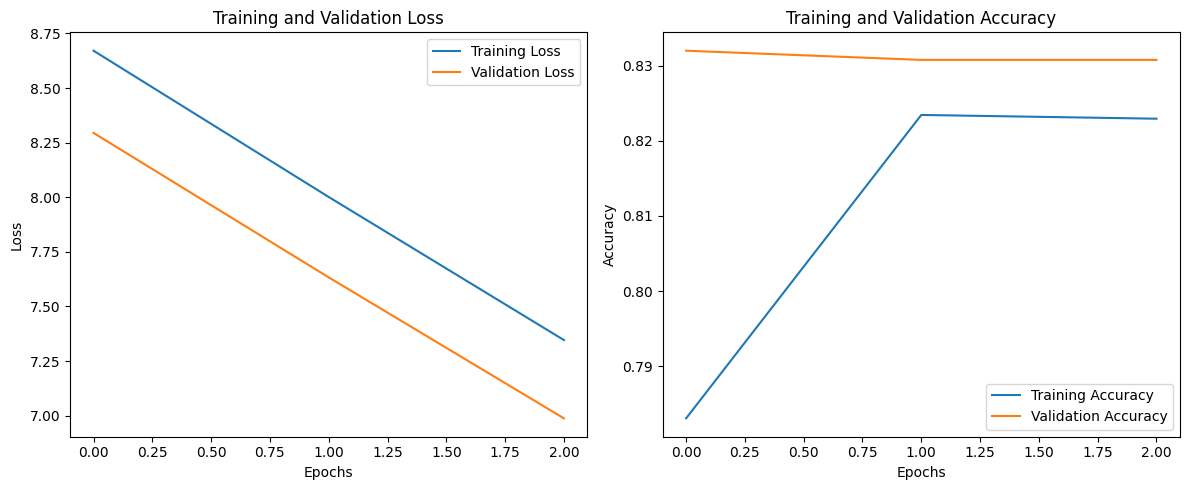

Validation Loss: 7.0513
Validation Accuracy: 0.7932


In [17]:
''' EarlyStopping '''
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

pad.shape, pad2.shape, (pad2.reshape(pad2.shape[0], pad2.shape[1], 1)).shape

''' training '''
# The target data (pad2) should not be reversed when passed to the model during training.
# The decoder GRU is designed to predict the next word in the sequence,
# and reversing the target would disrupt this process.
history = model.fit([pad, pad2], pad2.reshape(pad2.shape[0], pad2.shape[1], 1), epochs=3,  batch_size=512,
                    callbacks=[es], validation_split=0.2)

# Plotting Loss dan Akurasi
plt.figure(figsize=(12, 5))

# Plot untuk Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot untuk Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluasi akhir pada data validasi
val_loss, val_accuracy = model.evaluate([pad, pad2[::-1]], pad2.reshape(pad2.shape[0], pad2.shape[1], 1), verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


# Evaluasi

In [18]:
# Menghitung BLEU score pada data validasi
def calculate_bleu(model, x_val, y_val):
    bleu_scores = []
    for i in range(len(x_val)):
        predicted_seq = model.predict(x_val[i:i+1])  # Prediksi urutan output untuk tiap contoh
        predicted_seq = np.argmax(predicted_seq, axis=-1)  # Mendapatkan index dengan probabilitas tertinggi

        # BLEU score dengan nltk - sesuaikan y_val[i] sebagai list token referensi
        reference = [y_val[i].tolist()]
        candidate = predicted_seq.flatten().tolist()
        bleu_score = sentence_bleu(reference, candidate)
        bleu_scores.append(bleu_score)
    return np.mean(bleu_scores)

# Menghitung BLEU pada data validasi
bleu_score = calculate_bleu(model, [pad, pad2[::-1]], pad2)
print(f"Validation BLEU Score: {bleu_score:.4f}")


ValueError: Layer "functional" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(32, 2978) dtype=int32>]

# Latihan

1. Bangun Model Multilayer GRU dengan Minimal 3 Lapisan pada Encoder
Buatlah sebuah model GRU dengan minimal 3 lapisan GRU pada bagian encoder. Pastikan
setiap lapisan GRU terhubung secara berurutan sehingga keluaran dari satu lapisan GRU
menjadi masukan ke lapisan GRU berikutnya. Pahami bagaimana keluaran dari lapisan
terakhir encoder GRU akan digunakan dalam proses prediksi.


2. Modifikasi Dimensi Word Embedding
Sebelum masukan diproses oleh lapisan GRU, gunakan embedding layer untuk memetakan
setiap kata dalam teks ke dalam ruang vektor berdimensi tetap. Cobalah beberapa dimensi
embedding yang berbeda (misalnya 50, 100, dan 200, pilih satu) dan amati bagaimana
perubahan dimensi ini memengaruhi performa model. Gunakan metrik loss dan accuracy
untuk mengevaluasi model pada training dan validation set. Gunakanlah batch size yang lebih
kecil dan epoch yang kecil untuk mempercepat waktu trainning.

## Model Multilayer GRU dengan Minimal 3 Lapisan

In [19]:
K.clear_session()

# Define hyperparameters
latent_dim = 16  # Dimension of the hidden state
embedding_dim = 50  # Dimension of the word embeddings


encoder_inputs = Input(shape=(pad.shape[1],))  # Shape of input plot sequences
encoder_embedding = Embedding(voc_size, embedding_dim)(encoder_inputs)

# GRU Layer 1
encoder_gru1 = GRU(latent_dim, return_sequences=True, return_state=True)
encoder_outputs1, state_h1 = encoder_gru1(encoder_embedding)

# GRU Layer 2
encoder_gru2 = GRU(latent_dim, return_sequences=True, return_state=True)
encoder_outputs2, state_h2 = encoder_gru2(encoder_outputs1)

# GRU Layer 3
encoder_gru3 = GRU(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder_gru3(encoder_outputs2)


encoder_states = [state_h]

# Decoder
decoder_inputs = Input(shape=(pad2.shape[1],))  # Shape of input title sequences
# voc_size2 should be large enough to cover all possible values in pad2
decoder_embedding = Embedding(voc_size2, embedding_dim)(decoder_inputs)
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

# Ensure that the decoder output layer (decoder_dense) has the correct size
decoder_dense = Dense(voc_size2, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs) # Apply the dense layer to the decoder outputs

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2978)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 2978, 50)       │      4,298,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ [(None, 2978, 16),     │          3,264 │ embedding[0][0]        │
│                           │ (None, 16)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ [(None, 2978, 16),     │          1,632 │ gru[0][0]              │
│                           │ (None, 16)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 15, 50)         │        402,100 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ [(None, 2978, 16),     │          1,632 │ gru_1[0][0]            │
│                           │ (None, 16)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_3 (GRU)               │ [(None, 15, 16),       │          3,264 │ embedding_1[0][0],     │
│                           │ (None, 16)]            │                │ gru_2[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 15, 8042)       │        136,714 │ gru_3[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,846,606 (18.49 MB)

 Trainable params: 4,846,606 (18.49 MB)

 Non-trainable params: 0 (0.00 B)

## Modifikasi Dimensi Word Embedding Sebelum masukan diproses oleh lapisan GRU

In [20]:
K.clear_session()

# Define hyperparameters
latent_dim = 16  # Dimension of the hidden state
embedding_dim = 50

encoder_inputs = Input(shape=(pad.shape[1],))  # Shape of input plot sequences
encoder_embedding = Embedding(voc_size, embedding_dim)(encoder_inputs)

# GRU Layer 1
encoder_gru1 = GRU(latent_dim, return_sequences=True, return_state=True)
encoder_outputs1, state_h1 = encoder_gru1(encoder_embedding)

# GRU Layer 2
encoder_gru2 = GRU(latent_dim, return_sequences=True, return_state=True)
encoder_outputs2, state_h2 = encoder_gru2(encoder_outputs1)

# GRU Layer 3
encoder_gru3 = GRU(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder_gru3(encoder_outputs2)


encoder_states = [state_h]

# Decoder
decoder_inputs = Input(shape=(pad2.shape[1],))  # Shape of input title sequences
# voc_size2 should be large enough to cover all possible values in pad2
decoder_embedding = Embedding(voc_size2, embedding_dim)(decoder_inputs)
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

# Ensure that the decoder output layer (decoder_dense) has the correct size
decoder_dense = Dense(voc_size2, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs) # Apply the dense layer to the decoder outputs

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2978)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 2978, 50)       │      4,298,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ [(None, 2978, 16),     │          3,264 │ embedding[0][0]        │
│                           │ (None, 16)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ [(None, 2978, 16),     │          1,632 │ gru[0][0]              │
│                           │ (None, 16)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 15, 50)         │        402,100 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ [(None, 2978, 16),     │          1,632 │ gru_1[0][0]            │
│                           │ (None, 16)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_3 (GRU)               │ [(None, 15, 16),       │          3,264 │ embedding_1[0][0],     │
│                           │ (None, 16)]            │                │ gru_2[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 15, 8042)       │        136,714 │ gru_3[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,846,606 (18.49 MB)

 Trainable params: 4,846,606 (18.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 432s 20s/step - accuracy: 0.6151 - loss: 8.8496 - val_accuracy: 0.8123 - val_loss: 8.3337
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 409s 19s/step - accuracy: 0.7993 - loss: 8.1683 - val_accuracy: 0.8123 - val_loss: 7.6358
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 444s 19s/step - accuracy: 0.7995 - loss: 7.4729 - val_accuracy: 0.8123 - val_loss: 6.9620


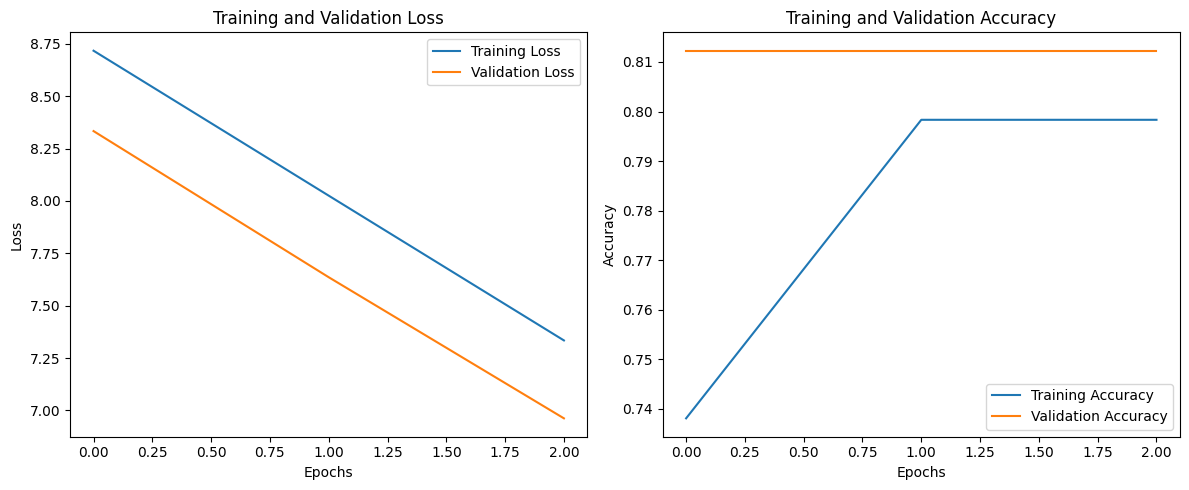

Validation Loss: 7.0033
Validation Accuracy: 0.8011


In [21]:
''' EarlyStopping '''
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

pad.shape, pad2.shape, (pad2.reshape(pad2.shape[0], pad2.shape[1], 1)).shape

''' training '''
# The target data (pad2) should not be reversed when passed to the model during training.
# The decoder GRU is designed to predict the next word in the sequence,
# and reversing the target would disrupt this process.
history = model.fit([pad, pad2], pad2.reshape(pad2.shape[0], pad2.shape[1], 1), epochs=3,  batch_size=512,
                    callbacks=[es], validation_split=0.2)

# Plotting Loss dan Akurasi
plt.figure(figsize=(12, 5))

# Plot untuk Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot untuk Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluasi akhir pada data validasi
val_loss, val_accuracy = model.evaluate([pad, pad2[::-1]], pad2.reshape(pad2.shape[0], pad2.shape[1], 1), verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
# # Evaluasi
# Menghitung BLEU score pada data validasi
def calculate_bleu(model, x_val, y_val):
    bleu_scores = []
    for i in range(len(x_val)):
        predicted_seq = model.predict(x_val[i:i+1])  # Prediksi urutan output untuk tiap contoh
        predicted_seq = np.argmax(predicted_seq, axis=-1)  # Mendapatkan index dengan probabilitas tertinggi

        # BLEU score dengan nltk - sesuaikan y_val[i] sebagai list token referensi
        reference = [y_val[i].tolist()]
        candidate = predicted_seq.flatten().tolist()
        bleu_score = sentence_bleu(reference, candidate)
        bleu_scores.append(bleu_score)
    return np.mean(bleu_scores)

# Menghitung BLEU pada data validasi
bleu_score = calculate_bleu(model, [pad, pad2[::-1]], pad2)
print(f"Validation BLEU Score: {bleu_score:.4f}")

# Analisis

### 1. Bagaimana perbandingan performa antara model multilayer GRU dan single layer
GRU dalam prediksi judul film?

single layer GRU<br>
- latent_dim = 16
- embedding_dim = 100
- epochs = 3
- batch size = 512

didapatkan Validation Loss: 7.0513 dan Validation Accuracy: 0.7932

multi layer GRU<br>
- latent_dim = 16
- embedding_dim = 50
- epochs = 3
- batch size = 512

didapatkan Validation Loss: 7.0033 dan Validation Accuracy: 0.8011

\
Model multilayer GRU, meskipun menggunakan dimensi embedding yang lebih kecil (50 vs 100), menunjukkan performa yang sedikit lebih baik daripada single layer GRU. Hal ini terlihat dari validation loss yang lebih rendah (7.0033 vs 7.0513) dan validation accuracy yang lebih tinggi (0.8011 vs 0.7932). Peningkatan performa ini kemungkinan disebabkan oleh kemampuan multilayer GRU untuk mempelajari representasi data yang lebih kompleks dan hierarkis berkat lapisan-lapisan tambahan. Dengan kata lain, penambahan lapisan GRU memungkinkan model untuk menangkap pola dan dependensi yang lebih rumit dalam data sekuensial, yang pada gilirannya menghasilkan prediksi judul film yang lebih akurat. Meskipun perbedaan performanya relatif kecil, multilayer GRU sedikit lebih baik pada percobaan diatas.

### 2. Apa dampak dari perubahan dimensi embedding terhadap performa model?
<br>

Mengurangi dimensi embedding dari 100 ke 50, meskipun dalam arsitektur multilayer, menghasilkan sedikit peningkatan performa. Validasi loss menurun sedikit (7.0513 menjadi 7.0033), dan validasi accuracy meningkat sedikit (0.7932 menjadi 0.8011). Hal ini menunjukkan bahwa dimensi embedding yang lebih kecil mungkin cukup untuk menangkap informasi penting dalam data, dan dapat membantu mencegah overfitting dengan mengurangi kompleksitas model. Namun, perbedaan performa relatif kecil.

### 3. Apa kekuatan dan kelemahan masing-masing model dalam menangkap pola plot untuk prediksi judul?

Single-layer GRU lebih sederhana, lebih cepat dilatih dan membutuhkan sumber daya komputasi yang lebih sedikit. Namun, masih kesulitan dalam menangkap dependensi jangka panjang dan pola kompleks dalam plot film karena hanya memiliki satu lapisan untuk memproses informasi. Multilayer GRU, dengan beberapa lapisannya, memiliki kapasitas yang lebih besar untuk mempelajari pola yang rumit dan dependensi jangka panjang dalam plot, yang berpotensi menghasilkan prediksi judul yang lebih akurat. Namun, model ini lebih kompleks, membutuhkan waktu pelatihan yang lebih lama, dan lebih rentan terhadap overfitting jika tidak diatur dengan hati-hati. Oleh karena itu pemilihan model terbaik bergantung pada trade-off antara kompleksitas, performa, dan sumber daya komputasi yang tersedia serta jenis proyek yang dikerjakan.

### 4. Bagaimana dampak waktu komputasi pada kedua model, dan apakah peningkatan
performa sepadan dengan waktu yang diperlukan?


Model GRU multilayer, meskipun membutuhkan waktu pelatihan lebih lama (23 menit vs 15 menit untuk single-layer), menunjukkan sedikit peningkatan performa dengan validation loss yang lebih rendah dan validation accuracy yang lebih tinggi. Hal ini menunjukkan bahwa kompleksitas dan waktu pelatihan tambahan dapat meningkatkan performa. Namun, peningkatannya relatif kecil, jadi untuk aplikasi yang sangat memperhatikan waktu pelatihan, GRU single-layer mungkin menjadi pilihan yang lebih baik, terutama jika perbedaan performa yang kecil dapat diterima. Jika peningkatan performa sedikit sangat penting dan waktu pelatihan tambahan dapat diterima, GRU multilayer mungkin dapat kita pilih. Namun, jika waktu pelatihan merupakan kendala utama dan perbedaan performa yang kecil tidak terlalu penting, GRU single-layer mungkin menjadi pilihan yang lebih baik.

### 5. Apakah model dengan word embedding yang lebih besar cenderung overfit?

model dengan dimensi word embedding yang lebih kecil (50 untuk GRU multilayer) menunjukkan kinerja yang sedikit lebih baik daripada model dengan dimensi embedding yang lebih besar (100 untuk GRU single-layer). Hal ini menunjukkan bahwa dalam percobaan diatas, word embedding yang lebih besar mungkin menyebabkan risiko overfitting yang sedikit lebih tinggi, yang berpotensi disebabkan oleh peningkatan kompleksitas model. Namun, perbedaan kinerjanya relatif kecil, dan faktor-faktor lain seperti arsitektur model (multilayer vs. single-layer) dan karakteristik dataset juga dapat mempengaruhi hasil akhir.